<h1> <center> GEOG 172: INTERMEDIATE GEOGRAPHICAL ANALYSIS </h1>
    <h2> <center> Evgeny Noi </h2>
        <h3> <center> Lecture 14: Clustering as Optimization and Clustering Diagnostics </h3>

# Review 

* Clustering is unsupervised partitioning of the data 
* Clustering (regionalization) looks at attribute simularity (and spatial proximity) 
* CLustering search for latent patterns in our data

# Note on LISA Clusters and Cluster Clusters

* LISA (Local indicators of spatial association) break down our observations into two groups based on **univariate** similarity and **geographic proximity**: 
    * spatial clusters (hotspots and coldspots) or (HH and LL)
    * spatial outliers (HL and LH) 
* Clustering algorithms break down data into clusters / groups / partitions based on **mutlivariate** similarity
* Regionalization algorithms break down data into clusters / groups / partitions based on **multivariate** similarity and **geographic proximity** 

# LISA Clusters $\neq$ Cluster Clusters

# Plan for today

1. Clustering types and associated pros/cons 
2. Clustering as spatial optimization 
3. Clustering diagnostics 

# Partitional Clustering (k-means and k-medoids) 

### Strengths: 
* Work well for spherical shape 
* Scalable with respect to algorithm complexity 

### Weaknesses: 
* Not suited for complex shape
* Do not work for clusters with different density 

# Hierarchical Clustering (AHC) 

### Strengths: 
* Reveal finer level details about the data 
* Interpretable dendrogram 

### Weaknesses: 
* Computationally expensive with respect to algorithm complexity 
* Sensitive to noise and outliers 

# Density-based Clustering (DBSCAN) 

### Strengths: 
* Capture clusters of non-spherical shape
* Resistant to outliers

### Weaknesses: 
* Not suited for clustering in high-dimensional spaces 
* Troble capturing the clusters of varying densities

# Clustering Diagnostics 

* Most of the algorithms we ran on data had a pre-determined number of clusters, **BUT** the number of clusters must be tailored to data that we are working with. 
* Many different diagnostics 

# Elbow Method 

* Clustering is run for different number of $k$ clusters - mapped onto $x$-axis 
* Sum of squared error (SSE) - sum of the squared Euclidean distances of each point to its closest centroid - mapped onto $y$-axis
* The elbow point denotes the optimal number of clusters

In [69]:
import pandas as pd
import geopandas as gpd
from esda.moran import Moran
from libpysal.weights import Queen, KNN
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pingouin as pg
from sklearn.cluster import AgglomerativeClustering
from sklearn_extra.cluster import KMedoids

In [4]:
from libpysal.examples import load_example, available

cin = load_example('Cincinnati')
cin.get_file_list()

['C:\\Users\\barguzin\\AppData\\Local\\pysal\\pysal\\Cincinnati\\walnuthills_updated\\.DS_Store',
 'C:\\Users\\barguzin\\AppData\\Local\\pysal\\pysal\\Cincinnati\\walnuthills_updated\\cincinnati.dbf',
 'C:\\Users\\barguzin\\AppData\\Local\\pysal\\pysal\\Cincinnati\\walnuthills_updated\\cincinnati.prj',
 'C:\\Users\\barguzin\\AppData\\Local\\pysal\\pysal\\Cincinnati\\walnuthills_updated\\cincinnati.shp',
 'C:\\Users\\barguzin\\AppData\\Local\\pysal\\pysal\\Cincinnati\\walnuthills_updated\\cincinnati.shx',
 'C:\\Users\\barguzin\\AppData\\Local\\pysal\\pysal\\Cincinnati\\__MACOSX\\walnuthills_updated\\._.DS_Store']

In [6]:
cin_df = gpd.read_file(cin.get_path('cincinnati.shp'))
print(cin_df.shape)
cin_df.head()

(457, 73)


,ID,AREA,BLOCK,BG,TRACT,COUNTY,MSA,POPULATION,MALE,FEMALE,...,OWNER_SIZE,RENTER_SIZ,DENSITY,BURGLARY,ASSAULT,THEFT,BURG_D,ASSALT_D,THEFT_D,geometry
0,726907.0,0.09,390610042002001,390610042002,39061004200,39061,1640,479.0,221.0,258.0,...,1.46,1.42,5384.7901,1,0,4,1.0,0.0,1.0,"POLYGON ((1407302.966 415693.734, 1407473.141 ..."
1,695744.0,0.01,390610022004003,390610022004,39061002200,39061,1640,85.0,39.0,46.0,...,3.22,2.15,6643.1423,0,2,2,0.0,1.0,1.0,"POLYGON ((1398841.243 416718.444, 1399605.382 ..."
2,695762.0,0.01,390610033002017,390610033002,39061003300,39061,1640,29.0,18.0,11.0,...,1.00,1.33,4326.5018,0,0,0,0.0,0.0,0.0,"POLYGON ((1398733.468 416975.853, 1398794.240 ..."
3,695780.0,0.01,390610022004002,390610022004,39061002200,39061,1640,117.0,59.0,58.0,...,2.57,2.25,20784.6991,2,3,4,1.0,1.0,1.0,"POLYGON ((1399564.078 416046.633, 1399605.382 ..."
4,695798.0,0.02,390610033001009,390610033001,39061003300,39061,1640,96.0,51.0,45.0,...,1.00,1.42,4019.0506,0,0,2,0.0,0.0,1.0,"POLYGON ((1398841.243 416718.444, 1398733.468 ..."


In [10]:
cin_df2 = cin_df.copy()
# calculate centroid locs
cin_df2['lng'] = cin_df2.centroid.x
cin_df2['lat'] = cin_df2.centroid.y
# pct vars 
cin_df2['pct_nhwhite'] = cin_df2.NH_WHITE / cin_df2.POPULATION
cin_df2['pct_elder']  = cin_df2.AGE_65 / cin_df2.POPULATION
cin_df2['pct_own'] = cin_df2.OCCHU_OWNE / cin_df2.HSNG_UNITS
cin_df2['pct_rent'] = cin_df2.OCCHU_RENT / cin_df2.HSNG_UNITS
cin_df2['pct_vac'] = cin_df2.HU_VACANT / cin_df2.HSNG_UNITS
cin_df2 = cin_df2.fillna(0)
new_predictors = ['POPULATION', 'MEDIAN_AGE', 'lng', 'lat', 'pct_elder', 'pct_own', 'pct_rent', 'pct_vac']

In [23]:
cin_df2[new_predictors].describe().round(2)

,POPULATION,MEDIAN_AGE,lng,lat,pct_elder,pct_own,pct_rent,pct_vac
count,457.00,457.00,457.00,457.00,457.00,457.00,457.00,457.00
mean,84.71,27.19,1401850.14,417557.33,0.09,0.19,0.49,0.16
std,131.43,15.98,3273.84,2996.38,0.12,0.22,0.32,0.18
min,0.00,0.00,1393996.51,411393.22,0.00,0.00,0.00,0.00
25%,12.00,21.20,1399599.35,415586.99,0.00,0.00,0.21,0.00
50%,46.00,28.50,1401991.01,417271.52,0.06,0.13,0.55,0.12
75%,105.00,36.50,1403949.00,419286.57,0.12,0.29,0.74,0.21
max,1451.00,83.00,1411132.54,425511.77,1.00,1.00,1.00,1.00


In [24]:
from sklearn.preprocessing import robust_scale

db_scaled = robust_scale(cin_df2[new_predictors])

pd.DataFrame(db_scaled, columns=cin_df2[new_predictors].columns).describe().round(2)

,POPULATION,MEDIAN_AGE,lng,lat,pct_elder,pct_own,pct_rent,pct_vac
count,457.00,457.00,457.00,457.00,457.00,457.00,457.00,457.00
mean,0.42,-0.09,-0.03,0.08,0.23,0.21,-0.12,0.14
std,1.41,1.04,0.75,0.81,0.97,0.78,0.61,0.86
min,-0.49,-1.86,-1.84,-1.59,-0.52,-0.46,-1.06,-0.59
25%,-0.37,-0.48,-0.55,-0.46,-0.52,-0.46,-0.65,-0.59
50%,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
75%,0.63,0.52,0.45,0.54,0.48,0.54,0.35,0.41
max,15.11,3.56,2.10,2.23,7.81,3.04,0.86,4.16


In [34]:
from sklearn.cluster import KMeans
import os
import warnings

os.environ["OMP_NUM_THREADS"] = '2'
warnings.filterwarnings('ignore')

kmeans = KMeans(n_clusters=5, init='random', n_init=10, max_iter=300, random_state=32)

k5cls = kmeans.fit(db_scaled)

k5cls.labels_[:5]

array([2, 0, 0, 0, 0])

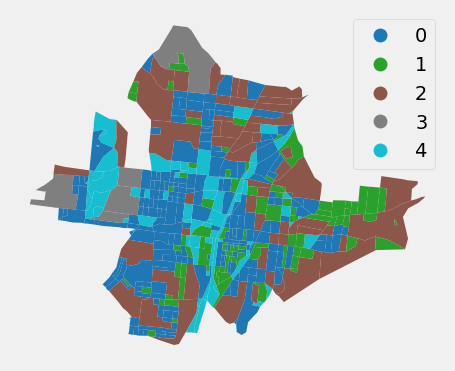

In [65]:
cin_df2["k5cls"] = k5cls.labels_
f, ax = plt.subplots(1, figsize=(5, 5))
cin_df2.plot(column="k5cls", categorical=True, legend=True, linewidth=0, ax=ax)
ax.set_axis_off()
plt.show()

In [66]:
cin_df2.k5cls.value_counts()

0    226
1     92
4     78
2     56
3      5
Name: k5cls, dtype: int64

In [37]:
kmeans_kwargs = {
    "init": "random",
    "n_init": 10,
    "max_iter": 300,
    "random_state": 42
}

# A list holds the SSE values for each k
sse = []
for k in range(1, 14):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(db_scaled)
    sse.append(kmeans.inertia_)

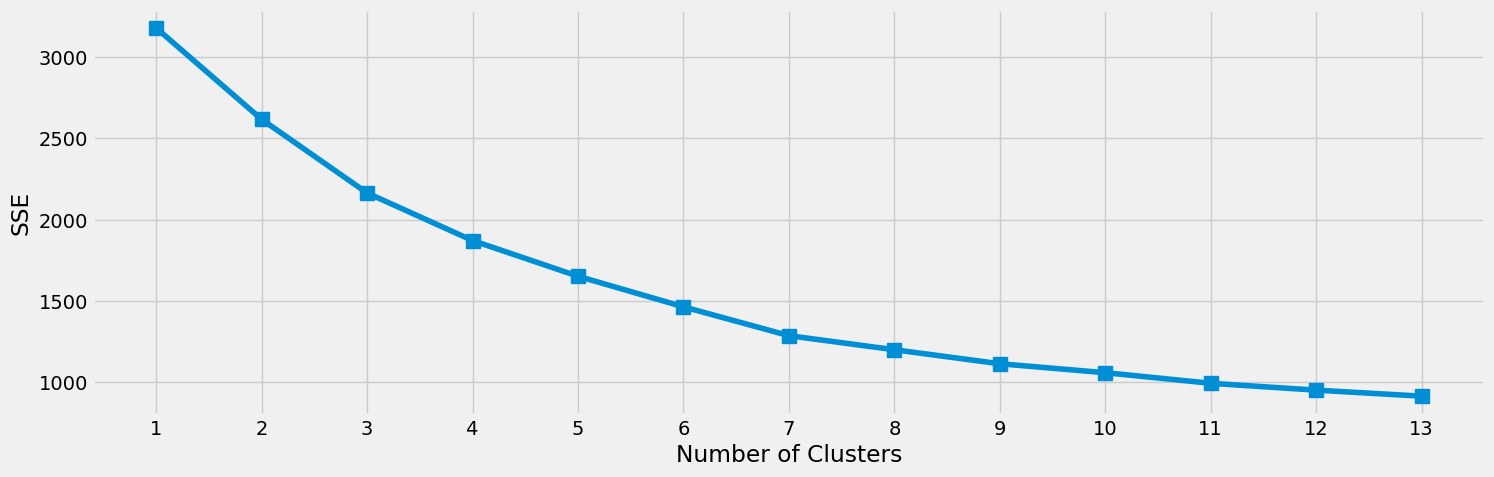

In [46]:
plt.style.use("fivethirtyeight")
f,ax=plt.subplots(figsize=(16,5))
ax.plot(range(1, 14), sse, 's-', markersize=10)
ax.set_xticks(range(1, 14))
ax.set_xlabel("Number of Clusters")
ax.set_ylabel("SSE")
plt.show()

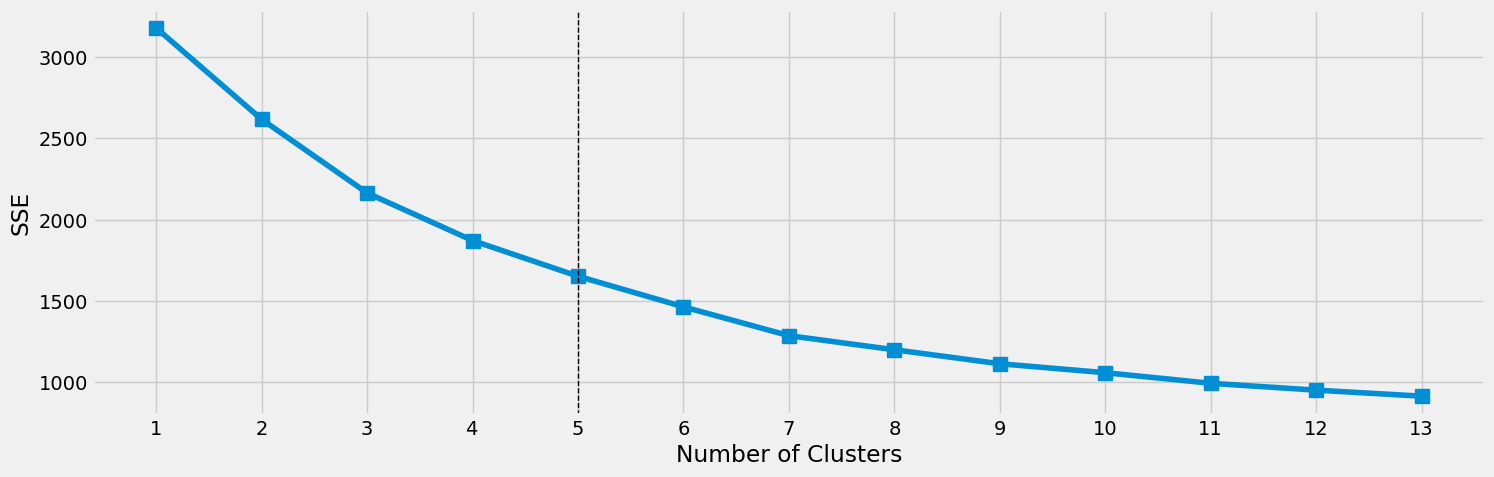

In [56]:
from kneed import KneeLocator
kl = KneeLocator(range(1, 14), sse, curve="convex", direction="decreasing")
f,ax=plt.subplots(figsize=(16,5))
ax.plot(range(1, 14), sse, 's-', markersize=10)
ax.axvline(x=kl.elbow, color='k', linestyle='dashed', lw=1) # add vertical line
ax.set_xticks(range(1, 14))
ax.set_xlabel("Number of Clusters")
ax.set_ylabel("SSE")
plt.show()

# Silhouette Coefficient

> The silhouette coefficient is a measure of cluster cohesion and separation. It quantifies how well a data point fits into its assigned cluster based on two factors: closeness within clusters, separation between clusters 

* ranges from -1 to +1
* +1 (good separation), -1 (mismatched clusters) 

In [59]:
from sklearn.metrics import silhouette_score
silhouette_coefficients = []

# Notice you start at 2 clusters for silhouette coefficient
for k in range(2, 14):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(db_scaled)
    score = silhouette_score(db_scaled, kmeans.labels_)
    silhouette_coefficients.append(score)

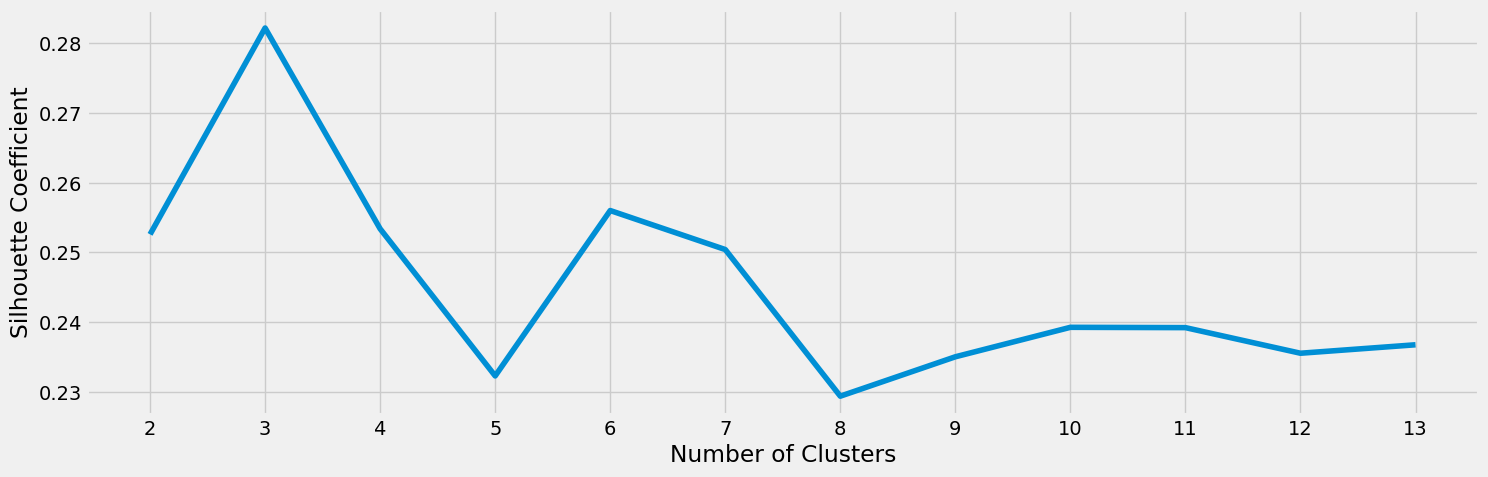

In [61]:
f,ax = plt.subplots(figsize=(16,5))
plt.plot(range(2, 14), silhouette_coefficients)
ax.set_xticks(range(2, 14))
ax.set_xlabel("Number of Clusters")
ax.set_ylabel("Silhouette Coefficient")
plt.show()

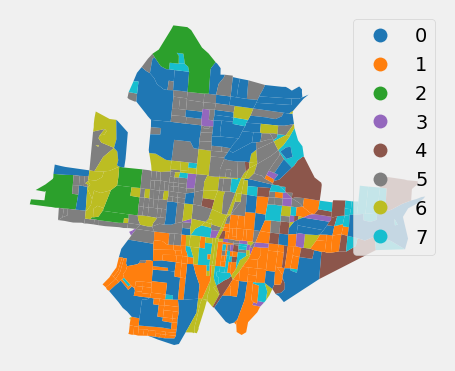

In [67]:
kmeans = KMeans(n_clusters=8, init='random', n_init=10, max_iter=300, random_state=32)
k8cls = kmeans.fit(db_scaled)
cin_df2["k8cls"] = k8cls.labels_
f, ax = plt.subplots(1, figsize=(5, 5))
cin_df2.plot(column="k8cls", categorical=True, legend=True, linewidth=0, ax=ax)
ax.set_axis_off()
plt.show()

# Geographic Coherence 

> Measures the compactness of a given shape 

* Isoperimetric Quotient. More compact shapes have an IPQ closer to 1, whereas very elongated or spindly shapes will have IPQs closer to zero 

$$
IPQ_i= \frac{A_i}{A_c} = \frac{4\pi A_i}{P_i^2}
$$

In [76]:
crime_vars = ['BURGLARY', 'ASSAULT', 'THEFT']
scaled_crime = robust_scale(cin_df[crime_vars])
w = Queen.from_dataframe(cin_df)
w_knn = KNN.from_dataframe(cin_df, k=5)

km = KMeans(n_clusters=5).fit(scaled_crime)
ahc = AgglomerativeClustering(linkage="ward", n_clusters=5).fit(scaled_crime) 
loccon = AgglomerativeClustering(linkage="ward", connectivity=w.sparse, n_clusters=5).fit(scaled_crime) 
loccon_knn = AgglomerativeClustering(linkage="ward", connectivity=w_knn.sparse, n_clusters=5).fit(scaled_crime) 

cin_df["hierar"] = ahc.labels_
cin_df["kmeans"] = km.labels_
cin_df["loc_que"] = loccon.labels_
cin_df['loc_knn'] = loccon_knn.labels_

In [79]:
results = []
for cluster_type in ("kmeans", "hierar", "loc_que", "loc_knn"):
    # compute the region polygons using a dissolve
    regions = cin_df[[cluster_type, "geometry"]].dissolve(by=cluster_type)
    # compute the actual isoperimetric quotient for these regions
    ipqs = (
        regions.area * 4 * np.pi / (regions.boundary.length ** 2)
    )
    # cast to a dataframe
    result = ipqs.to_frame(cluster_type)
    results.append(result)
# stack the series together along columns
pd.concat(results, axis=1)

,kmeans,hierar,loc_que,loc_knn
0,0.068724,0.042670,0.087802,0.113951
1,0.018618,0.027901,0.092131,0.292960
2,0.043537,0.019498,0.320167,0.398854
3,0.020728,0.060804,0.430195,0.157503
4,0.022123,0.020271,0.193330,0.430195


# Goodness of Fit Measures 

* Silhoette Score - the average standardized distance from each observation to its “next best fit” cluster
* Calinski-Harabasz Score - the within-cluster variance divided by the between-cluster variance

In [81]:
from sklearn import metrics
ch_scores = []
for cluster_type in ("kmeans", "hierar", "loc_que", "loc_knn"):
    # compute the CH score
    ch_score = metrics.calinski_harabasz_score(
        # using scaled variables
        robust_scale(cin_df[crime_vars]),
        # using these labels
        cin_df[cluster_type],
    )
    # and append the cluster type with the CH score
    ch_scores.append((cluster_type, ch_score))

# re-arrange the scores into a dataframe for display
pd.DataFrame(
    ch_scores, columns=["cluster type", "CH score"]
).set_index("cluster type")

,CH score
cluster type,
kmeans,290.037212
hierar,260.895779
loc_que,31.032053
loc_knn,46.003501


# Interpreting CH score 

> Higher CH score indicates greater fit. We see that imposing contiguity constraints yields worse fits. 

# Clustering as Spatial Optimization

### Optimization (Mathematical Programming) 

> Mathematical programming is the selection of a best element, with regard to some criterion, from some set of available alternatives

> Maximizing or minimizing some function relative to some set, often representing a range of choices available in a certain situation

# Mathematical Optimization 

* Manufacturing and Production 
* Transportation 
* Scheduling 
* Networks 
* etc. 

# Parts of Optimization Problem 

1. Objective function $f(x)$ - maximizing or minimizing 
2. Variables ($x_1, x_2, ..., x_n$) and **decision variables** 
3. Constraints - puts limits on the magnitude and values of variables (equality or inequaility)

# Spatial Optimization 

* Deals with locational decisions 
    * MCLP - maximal covering location problem
    * ACLP - anti-covering location problem 
    * LSCP - location-set covering problem 
    * Location-Allocation problem 

# MCLP 

* **Objective**: cover as much of demand as possible 
* **Variables**: demand points, **Decision Variables**: facility locations 
* **Constraints**: locate $p$ facilities

# MCLP 

Given, $p$ (number of facilities), $a_i$ (service load at location $i$), $y_i$ (1 if demands $i$ is covered, 0 otherwise):

$$
\text{Maximize} \quad \sum_{i=1}^{n} a_i y_i
$$

Subject to: 

$$
\sum_{j \in N_i}^{} x_j \geq y_i \quad \forall i \quad \text{if coverage is provided}\\
\sum_{j}^{} x_j \geq p \quad \text{locate at least p facilities} \\
x_i \in \{ 0,1 \}, y_i \in \{ 0,1 \}
$$


# k-Means as a Math Optimization Problem

Given the set of observations ($x_1, x_2, ..., x_n$) partition $n$ observations into $k$ sets $S$ as as to minimize the within cluster sum of squares (variance): 

$$
\text{arg min}_s \sum_{i=1}^{k} \sum_{x \in S_i}^{} ||x - \mu||^2 
$$

# Questions? 

## Please submit your Interim reports by **Sunday midnight, 11/13**